# Developing an AI application

Going forward, AI algorithms will be incorporated into more and more everyday applications. For example, you might want to include an image classifier in a smart phone app. To do this, you'd use a deep learning model trained on hundreds of thousands of images as part of the overall application architecture. A large part of software development in the future will be using these types of models as common parts of applications. 

In this project, you'll train an image classifier to recognize different species of flowers. You can imagine using something like this in a phone app that tells you the name of the flower your camera is looking at. In practice you'd train this classifier, then export it for use in your application. We'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) of 102 flower categories, you can see a few examples below. 

<img src='assets/Flowers.png' width=500px>

The project is broken down into multiple steps:

* Load and preprocess the image dataset
* Train the image classifier on your dataset
* Use the trained classifier to predict image content

We'll lead you through each part which you'll implement in Python.

When you've completed this project, you'll have an application that can be trained on any set of labeled images. Here your network will be learning about flowers and end up as a command line application. But, what you do with your new skills depends on your imagination and effort in building a dataset. For example, imagine an app where you take a picture of a car, it tells you what the make and model is, then looks up information about it. Go build your own dataset and make something new.

First up is importing the packages you'll need. It's good practice to keep all the imports at the beginning of your code. As you work through this notebook and find you need to import a package, make sure to add the import up here.

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Imports Numpy, PyTorch and TorchVision and other packages

import numpy as np

import torch
import torch.nn.functional as F
from torch import nn
from torch import optim

import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision import datasets, models, transforms

import matplotlib.pyplot as plt

import helper


## Load the data

Here you'll use `torchvision` to load the data ([documentation](http://pytorch.org/docs/0.3.0/torchvision/index.html)). The data should be included alongside this notebook, otherwise you can [download it here](https://s3.amazonaws.com/content.udacity-data.com/nd089/flower_data.tar.gz). The dataset is split into three parts, training, validation, and testing. For the training, you'll want to apply transformations such as random scaling, cropping, and flipping. This will help the network generalize leading to better performance. You'll also need to make sure the input data is resized to 224x224 pixels as required by the pre-trained networks.

The validation and testing sets are used to measure the model's performance on data it hasn't seen yet. For this you don't want any scaling or rotation transformations, but you'll need to resize then crop the images to the appropriate size.

The pre-trained networks you'll use were trained on the ImageNet dataset where each color channel was normalized separately. For all three sets you'll need to normalize the means and standard deviations of the images to what the network expects. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`, calculated from the ImageNet images.  These values will shift each color channel to be centered at 0 and range from -1 to 1.
 

### My own notes for this project

The images of flowers have variable dimensions, and all have three colour channels. If we use 3 x 224 x 224 then the inputs will be 150,528!!! vgg16 has 25088 in_features, and 1000 out_features. So somehow, I need to feed the 224x224x3 images into a classifier expecting 25088 in_features. In Part 8, this seems to just "happen". 

For training purposes, I need to reduce this somewhat so that a) it is compatible with the pre-trained model, and b) that it is computationally manageable. 

Outputs should be 102 as there are 102 flower categories. The names are being loaded into a dictionary cat_to_name. 

In [2]:
data_dir = 'flowers'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'

In [3]:
# TODO: Define your transforms for the training, validation, and testing sets

# Allow the use of different batch sizes 
local_batch_size = 4

# keeping image size to 224 for training
# random crop between 50% and 75%
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(256, [0.5, 0.9]), # scaling
                                       transforms.CenterCrop(224),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])
                                       ])


# keeping image size to 224, as original image sizes vary
data_transforms = transforms.Compose([transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])
                                      ])


# Load train set with ImageFolder and define the dataloader

trainset = torchvision.datasets.ImageFolder(train_dir,
                                            transform = train_transforms) 
trainloader = torch.utils.data.DataLoader(trainset, batch_size = local_batch_size,
                                          shuffle = True)

# Load valid set with ImageFolder and define the dataloader
validset = torchvision.datasets.ImageFolder(valid_dir,
                                            transform = data_transforms)
validloader = torch.utils.data.DataLoader(validset, batch_size = local_batch_size,
                                          shuffle = True)

# Load test set with ImageFolder and define the dataloader
testset = torchvision.datasets.ImageFolder(test_dir,
                                           transform = data_transforms)
testloader = torch.utils.data.DataLoader(testset, batch_size = local_batch_size,
                                         shuffle = True)

# Check imported items 
print('There are {} items in the trainset'.format(len(trainset)))
print('There are {} items in the trainloader'.format(len(trainloader)))
print('There are {} items in the valid'.format(len(validset)))
print('There are {} items in the validloader'.format(len(validloader)))
print('There are {} items in the test'.format(len(testset)))
print('There are {} items in the testloader'.format(len(testloader)))

There are 6552 items in the trainset
There are 1638 items in the trainloader
There are 818 items in the valid
There are 205 items in the validloader
There are 819 items in the test
There are 205 items in the testloader


### Label mapping

You'll also need to load in a mapping from category label to category name. You can find this in the file `cat_to_name.json`. It's a JSON object which you can read in with the [`json` module](https://docs.python.org/2/library/json.html). This will give you a dictionary mapping the integer encoded categories to the actual names of the flowers.

In [4]:
import json

with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

# Check to see a sample of the flower category names
list(cat_to_name.items())[:5]

[('21', 'fire lily'),
 ('3', 'canterbury bells'),
 ('45', 'bolero deep blue'),
 ('1', 'pink primrose'),
 ('34', 'mexican aster')]

torch.Size([4, 3, 224, 224])


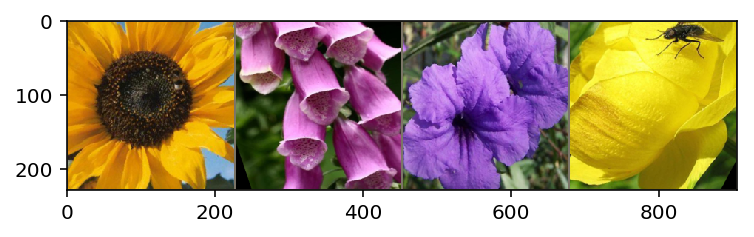

In [5]:
# This function shows the image parsed
def imgshow(imagedata, title = None):
    #print('Running imgshow function...')
    #print('-Image shape as a tensor:', imagedata.shape)    
    imagedata = imagedata.numpy().transpose((1,2,0)) #re-order array putting RGB as 3D
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    imagedata = std * imagedata + mean
    imagedata = np.clip(imagedata, 0, 1)    
    #print('-Image shape as an array:', imagedata.shape)
    
    plt.imshow(imagedata)

dataiter = iter(trainloader)
images, labels = dataiter.next()

print(images.shape)
    
imgshow(torchvision.utils.make_grid(images))

# Building and training the classifier

Now that the data is ready, it's time to build and train the classifier. As usual, you should use one of the pretrained models from `torchvision.models` to get the image features. Build and train a new feed-forward classifier using those features.

We're going to leave this part up to you. If you want to talk through it with someone, chat with your fellow students! You can also ask questions on the forums or join the instructors in office hours.

Refer to [the rubric](https://review.udacity.com/#!/rubrics/1663/view) for guidance on successfully completing this section. Things you'll need to do:

* Load a [pre-trained network](http://pytorch.org/docs/master/torchvision/models.html) (If you need a starting point, the VGG networks work great and are straightforward to use)
* Define a new, untrained feed-forward network as a classifier, using ReLU activations and dropout
* Train the classifier layers using backpropagation using the pre-trained network to get the features
* Track the loss and accuracy on the validation set to determine the best hyperparameters

We've left a cell open for you below, but use as many as you need. Our advice is to break the problem up into smaller parts you can run separately. Check that each part is doing what you expect, then move on to the next. You'll likely find that as you work through each part, you'll need to go back and modify your previous code. This is totally normal!

When training make sure you're updating only the weights of the feed-forward network. You should be able to get the validation accuracy above 70% if you build everything right. Make sure to try different hyperparameters (learning rate, units in the classifier, epochs, etc) to find the best model. Save those hyperparameters to use as default values in the next part of the project.

## Step 1
Load a pre-trained network (If you need a starting point, the VGG networks work great and are straightforward to use)


In [6]:
# TODO: Build and train your network
model = models.vgg16(pretrained = True)
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

"""
(classifier): Sequential(
    (0): Linear(in_features=25088, out_features=4096, bias=True)
    (1): ReLU(inplace)
    (2): Dropout(p=0.5)
    (3): Linear(in_features=4096, out_features=4096, bias=True)
    (4): ReLU(inplace)
    (5): Dropout(p=0.5)
    (6): Linear(in_features=4096, out_features=1000, bias=True)
)
"""

## Step 2
Define a new, untrained feed-forward network as a classifier, using ReLU activations and dropout

In [7]:
# Creating my own classifer for this project

# Freeze parameters so we don't backprop through them. Done before assigning the new classifier layer.
for param in model.parameters():
    param.requires_grad = False # but this fails on Udacity's implementation. 
    
# determine number of in_features in the last layer in the original classifer
n_inputs = model.classifier[6].in_features 

# replace the last layer in the classifier with this new layer
model.classifier[6] = nn.Sequential(
                        nn.Linear(n_inputs, 256),
                        nn.ReLU(),
                        nn.Dropout(0.5), # 50% chance drop out
                        nn.Linear(256, 102), # 102 is the number of flower categories
                        nn.LogSoftmax(dim = 1))

model.classifier

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace)
  (2): Dropout(p=0.5)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace)
  (5): Dropout(p=0.5)
  (6): Sequential(
    (0): Linear(in_features=4096, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5)
    (3): Linear(in_features=256, out_features=102, bias=True)
    (4): LogSoftmax()
  )
)

## Step 3
Train the classifier layers using backpropagation using the pre-trained network to get the features. 


In [8]:
# Determine wheterh there is a GPU, and use if available, else use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Training using', device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.classifier.parameters(), lr=0.001)

model.to(device)

model.train()

n_epochs = 3

for epoch in range(n_epochs):
    training_loss = 0
    count = 0 # this is to reduce the quantity of images used for training on local machine. 
    
    print('There are {} batches of images to train.'.format(len(trainloader)))
    
    # iterate images
    for images, category in iter(trainloader):
        images, category = images.to(device), category.to(device)
     
        # set parameter graidents to zero
        optimizer.zero_grad()
        
        # feed forward!
        outputs = model.forward(images)
        
        # backprop!
        loss = criterion(outputs, category) #this returns an array equivalent to batch size
        #print('loss:\n', loss)
        loss.backward() # feedback loss backword through the network
        
        optimizer.step()
        
        #print('loss.item\n', loss.item())
        training_loss += loss.item()
        
        # Show training progress
        print('Epoch: {}/{}...'.format(epoch+1, n_epochs), 
              'Training loss: {}'.format(training_loss/(count+1)))
        
        count += 1
        if count == 10:
            
            break
print('End.')

Training using cpu
There are 1638 batches of images to train.
Epoch: 1/3... Training loss: 4.725346565246582
Epoch: 1/3... Training loss: 4.660287141799927
Epoch: 1/3... Training loss: 4.609961986541748
Epoch: 1/3... Training loss: 4.6051377058029175
Epoch: 1/3... Training loss: 4.62878303527832
Epoch: 1/3... Training loss: 4.639547189076741
Epoch: 1/3... Training loss: 4.644291128431048
Epoch: 1/3... Training loss: 4.6341432929039
Epoch: 1/3... Training loss: 4.630799664391412
Epoch: 1/3... Training loss: 4.628548669815063
There are 1638 batches of images to train.
Epoch: 2/3... Training loss: 4.510746955871582
Epoch: 2/3... Training loss: 4.581016540527344
Epoch: 2/3... Training loss: 4.593079725901286
Epoch: 2/3... Training loss: 4.592203497886658
Epoch: 2/3... Training loss: 4.5693052291870115
Epoch: 2/3... Training loss: 4.570774396260579
Epoch: 2/3... Training loss: 4.602623530796596
Epoch: 2/3... Training loss: 4.600138008594513
Epoch: 2/3... Training loss: 4.587626563178168
Epo

## Step 4
Track the loss and accuracy on the validation set to determine the best hyperparameters.

_"You should be able to get the validation accuracy above 70% if you build everything right. Make sure to try different hyperparameters (learning rate, units in the classifier, epochs, etc) to find the best model. Save those hyperparameters to use as default values in the next part of the project."_

In [9]:
valid_loss = 0.0

with torch.no_grad():
    model.eval() # put model in evaluation mode
    
    # Run validation 
    count = 0
    for valid_images, labels in validloader:
        valid_images, labels = valid_images.to(device), labels.to(device)
        
        # Run forward pass
        outputs = model(valid_images)
        
        # TODO Calculate loss
        # loss = criterion(outputs, labels)
        # valid_loss += loss.item() * local_batch_size
        
        # TODO Calculate accuracy
        _, pred_labels = torch.max(outputs, dim=1)
              
        is_correct = (labels == pred_labels).sum().item()
        perc_accuracy = is_correct / local_batch_size
        print('Percentage of correct predictions: {:.2%}'.format(perc_accuracy))        
        
        # TODO calculate average accuracy
        
        count += 1
        if count == 10:
            break
        
model.train() # put model back into training mode. 
print('End.')

Percentage of correct predictions: 0.00%
Percentage of correct predictions: 0.00%
Percentage of correct predictions: 0.00%
Percentage of correct predictions: 0.00%
Percentage of correct predictions: 0.00%
Percentage of correct predictions: 0.00%
Percentage of correct predictions: 0.00%
Percentage of correct predictions: 0.00%
Percentage of correct predictions: 0.00%
Percentage of correct predictions: 0.00%
End.


## Testing your network

It's good practice to test your trained network on test data, images the network has never seen either in training or validation. This will give you a good estimate for the model's performance on completely new images. Run the test images through the network and measure the accuracy, the same way you did validation. You should be able to reach around 70% accuracy on the test set if the model has been trained well.

In [46]:
with torch.no_grad():
    model.eval() # put model in evaluation mode
    
    # Run validation 
    count = 0
    for test_images, labels in testloader:
        test_images, labels = test_images.to(device), labels.to(device)
        
        # Run forward pass
        # print(test_images.dtype)
        # print(test_images.shape)
        # pausebreak = input('pause')
        outputs = model(test_images)
        
        # Calculate loss
        # loss = criterion(outputs, labels)
        # valid_loss += loss.item() * local_batch_size
        
        # Calculate accuracy
        _, pred_labels = torch.max(outputs, dim=1)
              
        is_correct = (labels == pred_labels).sum().item()
        perc_accuracy = is_correct / local_batch_size
        print('Percentage of correct predictions: {:.2%}'.format(perc_accuracy))        
        
        # calculate average accuracy
        
        count += 1
        if count == 10:
            break
        
model.train() # put model back into training mode. 
print('End.')

Percentage of correct predictions: 0.00%
Percentage of correct predictions: 0.00%
Percentage of correct predictions: 0.00%
Percentage of correct predictions: 0.00%
Percentage of correct predictions: 0.00%
Percentage of correct predictions: 0.00%
Percentage of correct predictions: 0.00%
Percentage of correct predictions: 0.00%
Percentage of correct predictions: 0.00%
Percentage of correct predictions: 0.00%
End.


## Save the checkpoint

Now that your network is trained, save the model so you can load it later for making predictions. You probably want to save other things such as the mapping of classes to indices which you get from one of the image datasets: `image_datasets['train'].class_to_idx`. You can attach this to the model as an attribute which makes inference easier later on.

```model.class_to_idx = image_datasets['train'].class_to_idx```

Remember that you'll want to completely rebuild the model later so you can use it for inference. Make sure to include any information you need in the checkpoint. If you want to load the model and keep training, you'll want to save the number of epochs as well as the optimizer state, `optimizer.state_dict`. You'll likely want to use this trained model in the next part of the project, so best to save it now.

In [11]:
# TODO: Save the checkpoint 

def save_checkpoint(file_path):
    print('Starting save_checkpoint...\n')
    print('Model to save:\n', model, '\n')
    print('With the state_dict keys:\n', model.state_dict().keys(), '\n')
    
    checkpoint = {'model_state_dict': model.state_dict(),
                  'optimizer_state_dict': optimizer.state_dict()}
       
    print('Saving to file:',file_path, '\n')
    torch.save(checkpoint, file_path)
    
    return None

checkpoint_filename = input('Please enter checkpoint filename:')
save_checkpoint(checkpoint_filename)

Please enter checkpoint filename:ckpt_190117
Starting save_checkpoint...

Model to save:
 VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): M

## Loading the checkpoint

At this point it's good to write a function that can load a checkpoint and rebuild the model. That way you can come back to this project and keep working on it without having to retrain the network.

In [12]:
# TODO: Write a function that loads a checkpoint and rebuilds the model

def load_checkpoint(file_path):

    print('Starting load_checkpoint...\n')
    print('Loading from file:',file_path, '\n')
    checkpoint = torch.load(file_path)
    
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

    print('Model loaded:\n', model, '\n')
    
    return None
       
checkpoint_filename = input('Please enter checkpoint filename:')
load_checkpoint(checkpoint_filename)

Please enter checkpoint filename:ckpt_190117.pth
Starting load_checkpoint...

Loading from file: ckpt_190117.pth 

Model loaded:
 VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1,

# Inference for classification

Now you'll write a function to use a trained network for inference. That is, you'll pass an image into the network and predict the class of the flower in the image. Write a function called `predict` that takes an image and a model, then returns the top $K$ most likely classes along with the probabilities. It should look like 

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

First you'll need to handle processing the input image such that it can be used in your network. 

## Image Preprocessing

You'll want to use `PIL` to load the image ([documentation](https://pillow.readthedocs.io/en/latest/reference/Image.html)). It's best to write a function that preprocesses the image so it can be used as input for the model. This function should process the images in the same manner used for training. 

First, resize the images where the shortest side is 256 pixels, keeping the aspect ratio. This can be done with the [`thumbnail`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) or [`resize`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) methods. Then you'll need to crop out the center 224x224 portion of the image.

Color channels of images are typically encoded as integers 0-255, but the model expected floats 0-1. You'll need to convert the values. It's easiest with a Numpy array, which you can get from a PIL image like so `np_image = np.array(pil_image)`.

As before, the network expects the images to be normalized in a specific way. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`. You'll want to subtract the means from each color channel, then divide by the standard deviation. 

And finally, PyTorch expects the color channel to be the first dimension but it's the third dimension in the PIL image and Numpy array. You can reorder dimensions using [`ndarray.transpose`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.ndarray.transpose.html). The color channel needs to be first and retain the order of the other two dimensions.

In [54]:
def encode_float(xRGB):
    newRGB = (((xRGB - 128.0) / 128) +1) / 2
    return newRGB # this returns a float64


def process_image(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    print('Processing image ...')
    # TODO: Process a PIL image for use in a PyTorch model
    
    # Resize image to 256 shortest side
    width, height = image.size
    # print('Image original size:', image.size)    
    if width >= height:
        image = image.resize((int(width/height*256), 256), resample = 0)
    else:
        image = image.resize((256, int(height/width*256)), resample = 0)
    # print('New image size:', image.size)       
 
    # Crop the centre 224x224
    dim224 = 224
    width, height = image.size
    if (width or height) > dim224: 
        left = (width - dim224)/2
        top = (height - dim224)/2
        right = (width + dim224)/2
        bottom = (height + dim224)/2
        
        image = image.crop((left, top, right, bottom))
    else:
        image = image.resize((224, 224))
    
    # Re-organise RGB values
    encode_np_image = encode_float(np.array(image))
    
    # Nornalise for PyTorch
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    encode_np_image = (encode_np_image - mean)/std 
    #print('Image as 0-1 Numpy array normalised for PyTorch:\n', encode_np_image)
        
    # Transpose into the correct sequence of dimensions as PyTorch expect
    encode_tr_image = encode_np_image.transpose((2, 0, 1))
    encode_tr_image = encode_tr_image.astype(np.float32) # this is required as prediction requires float32
    
    # Returns a Numpy array
    return torch.tensor(encode_tr_image)

from PIL import Image

new_image = process_image(Image.open('flower1.jpg'))


Processing image ...


To check your work, the function below converts a PyTorch tensor and displays it in the notebook. If your `process_image` function works, running the output through this function should return the original image (except for the cropped out portions).

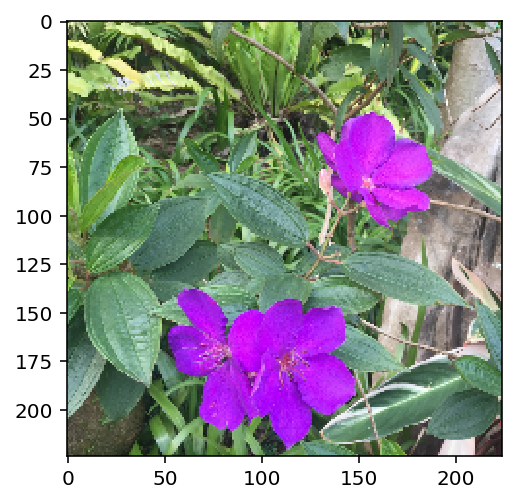

In [51]:
def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.numpy().transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

imshow(new_image)

## Class Prediction

Once you can get images in the correct format, it's time to write a function for making predictions with your model. A common practice is to predict the top 5 or so (usually called top-$K$) most probable classes. You'll want to calculate the class probabilities then find the $K$ largest values.

To get the top $K$ largest values in a tensor use [`x.topk(k)`](http://pytorch.org/docs/master/torch.html#torch.topk). This method returns both the highest `k` probabilities and the indices of those probabilities corresponding to the classes. You need to convert from these indices to the actual class labels using `class_to_idx` which hopefully you added to the model or from an `ImageFolder` you used to load the data ([see here](#Save-the-checkpoint)). Make sure to invert the dictionary so you get a mapping from index to class as well.

Again, this method should take a path to an image and a model checkpoint, then return the probabilities and classes.

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

In [150]:
def predict(image_path, model_to_use, topk=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    
    # TODO: Implement the code to predict the class from an image file
    print('\nRunning prediction...')
    # Process image
    image_predict = process_image(Image.open(image_path)) # already a tensor
    image_predict = image_predict.view(1, 3, 224, 224) # add batch to front
   
    # Evaluate
    with torch.no_grad():
        model_to_use.eval()
        output = model_to_use(image_predict) # this expects float32
        ps = torch.exp(output)
        
        topk, topclass = ps.topk(topk, dim = 1)
       
        return topk.numpy().squeeze(), topclass.numpy().squeeze()

probs, classes = predict('flower1.jpg', model, topk = 5)


Running prediction...
Processing image ...


## Sanity Checking

Now that you can use a trained model for predictions, check to make sure it makes sense. Even if the testing accuracy is high, it's always good to check that there aren't obvious bugs. Use `matplotlib` to plot the probabilities for the top 5 classes as a bar graph, along with the input image. It should look like this:

<img src='assets/inference_example.png' width=300px>

You can convert from the class integer encoding to actual flower names with the `cat_to_name.json` file (should have been loaded earlier in the notebook). To show a PyTorch tensor as an image, use the `imshow` function defined above.

Please enter image filename for checking: flower3.jpg

Running prediction...
Processing image ...
                       Probability
spring crocus             0.013106
giant white arum lily     0.012559
alpine sea holly          0.012490
cyclamen                  0.011759
bishop of llandaff        0.011696
Processing image ...


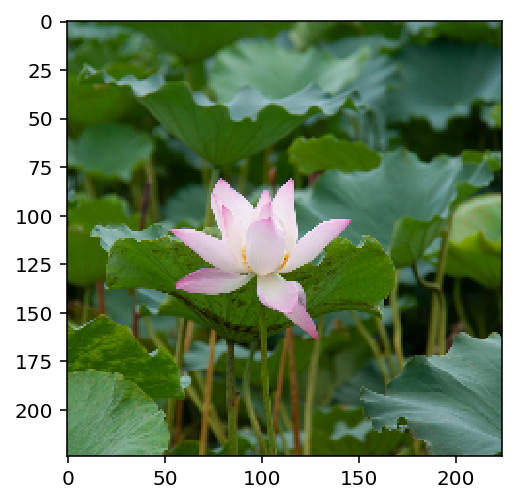

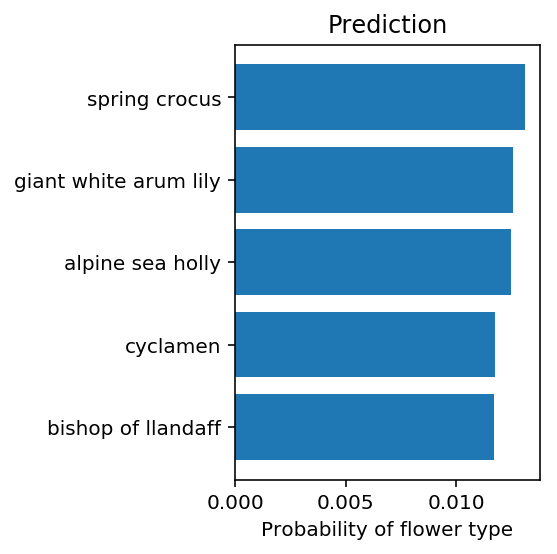

In [200]:
# TODO: Display an image along with the top 5 classes

import pandas as pd

def display_image_prediction(image_path, model_to_use, topk=5):
    
    # Predict!
    probs, classes = predict(image_path, model, topk = 5)
    
    # Convert class value to label
    named_classes = [cat_to_name[str(classes_)] for classes_ in classes]
    predicted_classes = pd.DataFrame({'Probability':probs}, named_classes)
    print(predicted_classes)
    
    # Process and show image
    this_image = process_image(Image.open(image_path))
    imshow(this_image)
    
    # Show predicted probabilities
    figure, axes = plt.subplots()
    y_pos = np.arange(len(predicted_classes))
    axes = plt.subplot(1, 2, 2)
    
    axes.set_title('Prediction')
    axes.set_xlabel('Probability of flower type')
    axes.set_yticks(y_pos)
    axes.set_yticklabels(predicted_classes.sort_values('Probability').index)
    axes.barh(y_pos, predicted_classes.sort_values('Probability').values.squeeze())
    plt.show()
    
    return

image_to_check = input('Please enter image filename for checking: ')
display_image_prediction(image_to_check, model, topk = 5)